In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import os
from sklearn.model_selection import train_test_split

In [2]:
path = 'C:/Users/jai matha di pc/Downloads/Speech_Emotion_Recognition_Model-master/Speech_Emotion_Recognition_Model-master/data/AudioWAV/'
audio_path = []
audio_emotion = []

In [3]:
directory_path = os.listdir(path)

In [4]:
for audio in directory_path:
    audio_path.append(path + audio)
    emotion = audio.split('_')
    if emotion[2] == 'SAD':
        audio_emotion.append("sad")
    elif emotion[2] == 'ANG':
        audio_emotion.append("angry")
    elif emotion[2] == 'DIS':
        audio_emotion.append("disgust")
    elif emotion[2] == 'NEU':
        audio_emotion.append("neutral")
    elif emotion[2] == 'HAP':
        audio_emotion.append("happy")
    elif emotion[2] == 'FEA':
        audio_emotion.append("fear")
    else:
        audio_emotion.append("unknown")

In [5]:
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)
print(dataset.head())


                                                Path Emotions
0  C:/Users/jai matha di pc/Downloads/Speech_Emot...    angry
1  C:/Users/jai matha di pc/Downloads/Speech_Emot...  disgust
2  C:/Users/jai matha di pc/Downloads/Speech_Emot...     fear
3  C:/Users/jai matha di pc/Downloads/Speech_Emot...    happy
4  C:/Users/jai matha di pc/Downloads/Speech_Emot...  neutral


## Visualization

<Axes: title={'center': 'Emotion Count'}, xlabel='Emotions', ylabel='Count'>

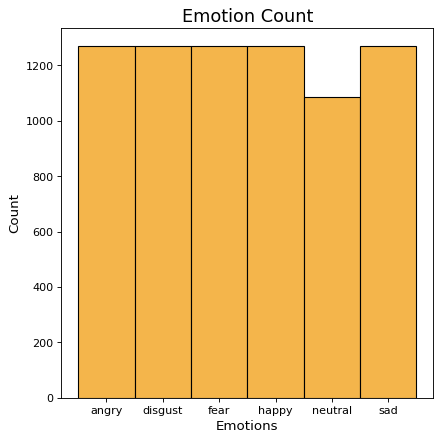

In [6]:
plt.figure(figsize=(6,6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Count', size = 12)
sns.histplot(dataset.Emotions, color='#F19C0E')

## Showing spectrogram and waveplot

In [7]:
emotion_sad = dataset[dataset['Emotions']=='sad']['Path']
print(type(emotion_sad))

<class 'pandas.core.series.Series'>


In [8]:
data_path = emotion_sad.values[542]
data, sampling_rate = librosa.load(data_path)

### Waveplot

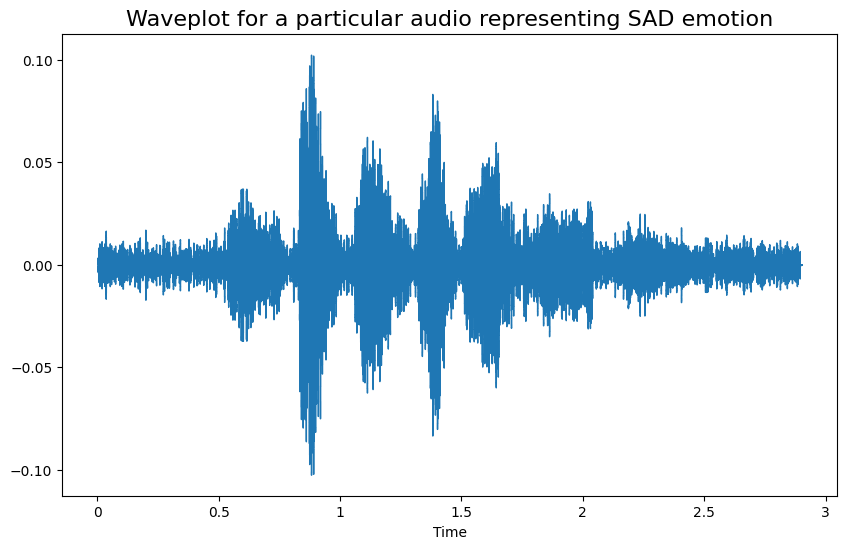

In [15]:
plt.figure(figsize=(10,6))
plt.title("Waveplot for a particular audio representing SAD emotion", size=16)
librosa.display.waveshow(data, sr=sampling_rate)

### Spectogram

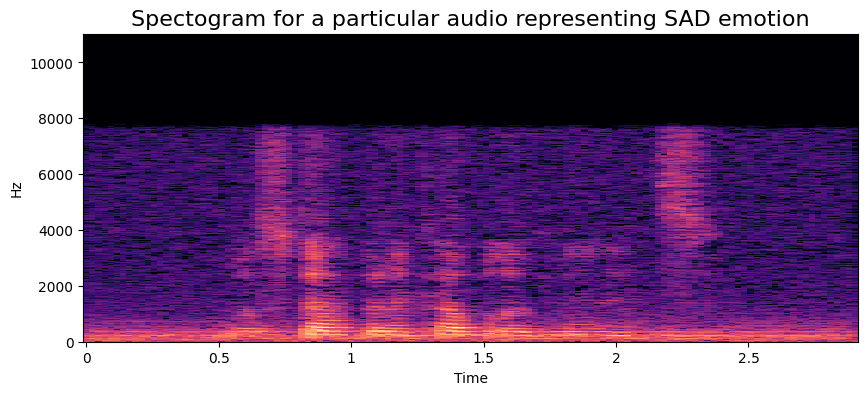

In [13]:
plt.figure(figsize=(10,4))
plt.title("Spectogram for a particular audio representing SAD emotion", size=16)
D = librosa.stft(data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, sr = sampling_rate, x_axis='time', y_axis='hz')

## Augmentation (Noise Injection)

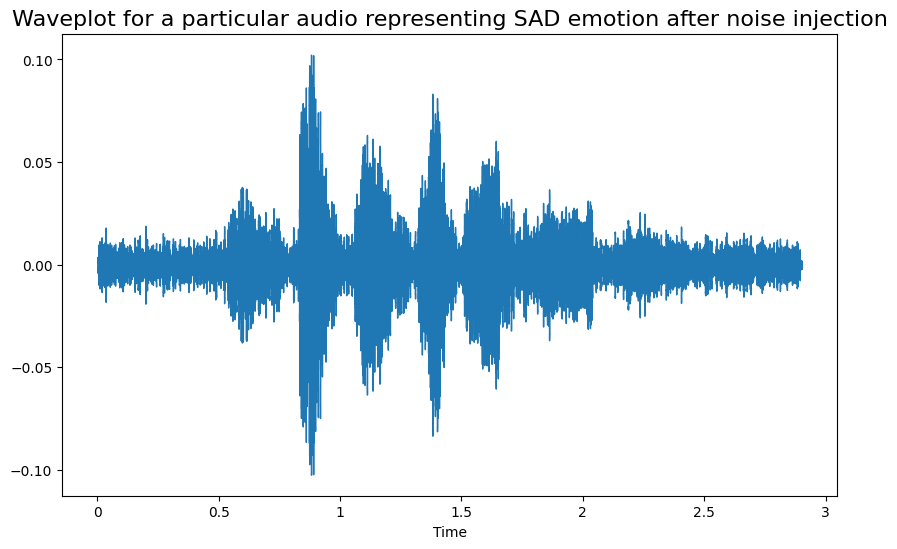

In [17]:
noise_amp = 0.035*np.random.uniform()*np.amax(data)
audio_injected_data = data + noise_amp*np.random.normal(size=data.shape[0])
plt.figure(figsize=(10,6))
plt.title("Waveplot for a particular audio representing SAD emotion after noise injection", size=16)
librosa.display.waveshow(audio_injected_data, sr=sampling_rate)
plt.show()

## Feature extraction

### Creating a DF with extracted Feautures

In [ ]:
X, Y = [], []
print("Feature processing...")

for path, emo, index in zip(dataset.Path, dataset.Emotions, range(len(dataset))):
    value, sample = librosa.load(path)
  
    noise_amp = 0.035 * np.random.uniform() * np.amax(value)
    value = value + noise_amp * np.random.normal(size=value.shape[0])
  
    mfcc = librosa.feature.mfcc(y=value, sr= sample, n_mfcc=13, n_fft=200, hop_length=512)
    mfcc = np.ravel(mfcc.T)
  
    mel = librosa.feature.melspectrogram(y=value, sr=sample, hop_length = 256, n_fft = 512, n_mels=64)
    mel = librosa.power_to_db(mel ** 2)
    mel = np.ravel(mel).T
    result = np.array([])
    result = np.hstack((result, mfcc, mel))
   
    result = np.array(result)
    X.append(result)
    Y.append(emo)

Feature processing...


In [16]:
extracted_audio_df = pd.DataFrame(X)
extracted_audio_df["emotion_of_audio"] = Y
print(extracted_audio_df.shape)
print(extracted_audio_df.tail(10))
extracted_audio_df = extracted_audio_df.fillna(0)

(7442, 30457)
               0          1          2          3          4          5  \
7432 -681.373551 -82.840426  13.205020  27.770437  18.854283  16.468140   
7433 -834.295720   0.242970  31.442112  21.022335 -14.324192 -18.603096   
7434 -805.844113 -20.488974   0.710674  32.114665  -7.145606   8.435484   
7435 -715.355859  -9.410126  -3.380515   8.170915  -7.560497  -8.925686   
7436 -687.339699 -35.639018  19.602638  14.008579  -9.161693   7.433288   
7437 -774.975083  18.806566  19.309730  23.059738  -8.494374  11.543960   
7438 -775.002614 -24.210463  22.741901  31.035140   9.789918  -9.133600   
7439 -557.279910 -95.991817 -12.337064  27.765570  21.020765  10.942931   
7440 -641.244277 -73.803682 -11.899944   4.443059  28.696044  -0.088765   
7441 -549.762427 -85.807858 -28.495460  22.738892  21.660334 -14.038658   

              6          7          8          9  ...  30447  30448  30449  \
7432 -11.831021 -29.358461  -2.281565  17.875039  ...    NaN    NaN    NaN   
7433

## Training

In [17]:
X = extracted_audio_df.drop(labels='emotion_of_audio', axis= 1)
Y = extracted_audio_df['emotion_of_audio']

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.2)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Model creation and fitting

In [19]:
mlp_model = MLPClassifier(activation='relu',
                         solver='sgd',
                         hidden_layer_sizes=100,
                         alpha=0.839903176695813,
                         batch_size=150,
                         learning_rate='adaptive',
                         max_iter=100000)
mlp_model.fit(x_train,y_train)

MLPClassifier(alpha=0.839903176695813, batch_size=150, hidden_layer_sizes=100,
              learning_rate='adaptive', max_iter=100000, solver='sgd')

## Accuracy calculation

In [20]:
y_pred = mlp_model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("\nModel:{}    Accuracy: {:.2f}%".
          format(type(mlp_model).__name__ , accuracy*100))


Model:MLPClassifier    Accuracy: 40.09%


## Prediction verification

In [21]:
print("The Prediction Made By Model: ")
print("<<<===========================================>>>")
df = pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
print(df.head())

The Prediction Made By Model: 
<<<===========================================>>>
       Actual  Predict
1011    angry    angry
1689  neutral  neutral
6092    angry    angry
6231    angry  disgust
7334  neutral  disgust
